# Large Movie Review Dataset v1.0

> Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

> Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a score >= 7 out of 10. Thus reviews with
more neutral ratings are not included in the train/test sets. In the
unsupervised set, reviews of any rating are included and there are an
even number of reviews > 5 and <= 5.

> Files

There are two top-level directories [train/, test/] corresponding to
the training and test sets. Each contains [pos/, neg/] directories for
the reviews with binary labels positive and negative. Within these
directories, reviews are stored in text files named following the
convention [[id]_[rating].txt] where [id] is a unique id and [rating] is
the star rating for that review on a 1-10 scale. For example, the file
[test/pos/200_8.txt] is the text for a positive-labeled test set
example with unique id 200 and star rating 8/10 from IMDb. The
[train/unsup/] directory has 0 for all ratings because the ratings are
omitted for this portion of the dataset.

We also include the IMDb URLs for each review in a separate
[urls_[pos, neg, unsup].txt] file. A review with unique id 200 will
have its URL on line 200 of this file. Due the ever-changing IMDb, we
are unable to link directly to the review, but only to the movie's
review page.

In addition to the review text files, we include already-tokenized bag
of words (BoW) features that were used in our experiments. These 
are stored in .feat files in the train/test directories. Each .feat
file is in LIBSVM format, an ascii sparse-vector format for labeled
data.  The feature indices in these files start from 0, and the text
tokens corresponding to a feature index is found in [imdb.vocab]. So a
line with 0:7 in a .feat file means the first word in [imdb.vocab]
(the) appears 7 times in that review.

> LIBSVM page for details on .feat file format:
http://www.csie.ntu.edu.tw/~cjlin/libsvm/

We also include [imdbEr.txt] which contains the expected rating for
each token in [imdb.vocab] as computed by (Potts, 2011). The expected
rating is a good way to get a sense for the average polarity of a word
in the dataset.

> Citing the dataset

When using this dataset please cite our ACL 2011 paper which
introduces it. This paper also contains classification results which
you may want to compare against.

In [55]:
!pip install wordcloud

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python312\\Scripts\\wordcloud_cli.exe' -> 'C:\\Python312\\Scripts\\wordcloud_cli.exe.deleteme'



In [75]:

import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nltk
import re
import matplotlib as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import seaborn as sns
import os
import tarfile
from wordcloud import WordCloud
import warnings 
warnings.filterwarnings('ignore')
# warnings.simplefilter(action='ignore', category=FutureWarnings)

ImportError: cannot import name 'TfidVectorizer' from 'sklearn.feature_extraction.text' (C:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py)

In [7]:
cd aclImdb

[WinError 2] The system cannot find the file specified: 'aclImdb'
C:\Users\Adachukwu\Desktop\DS Course\jupyter_notebook


In [8]:
#os.chdir("aclImdb")

In [9]:
print(os.listdir())

['.ipynb_checkpoints', '._rand-dollar.csv', '._SH_H2O_SAFE.xlsx', '1711392295-1243-f589d4e3-3b2f-4c7d-bdfc-f4a8b11eea91.zip', 'access_to_basic_services.csv', 'aclImdb_v1.tar.gz', 'Adachukwu Okafor Resume.pdf', 'Additional_resources_NLP.pdf', 'algorithms.py', 'An_introduction_to_version_control_markdown.pdf', 'Basic-Python-loops-examples.ipynb', 'Basic-Python-loops-exercises.ipynb', 'basic_python_functions_exercise.ipynb', 'big_o_notation_and_computational_complexity_examples.ipynb', 'billionaires.csv', 'Binary_classification_metrics_examples.ipynb', 'Binary_classification_metrics_exercise.ipynb', 'Casting_variables_to_different_data_types_example.ipynb', 'claims_data.csv', 'Classes_examples.ipynb', 'Classes_exercise.ipynb', 'Clean-coding-with-PEP-8.ipynb', 'Code-challenge-guide.ipynb', 'Code_challenge_Integrated_Project_P1_student_version.ipynb', 'Code_challenge_Integrated_Project_P1_student_version.zip', 'Code_challenge_loops_logic_functions_notebook.ipynb', 'cognifyz_internship.ipynb

In [14]:
cd

C:\Users\Adachukwu


In [15]:
print(os.listdir())

['.anaconda', '.android', '.astropy', '.bash_history', '.cache', '.conda', '.condarc', '.continuum', '.gitconfig', '.ipynb_checkpoints', '.ipython', '.jupyter', '.kivy', '.lesshst', '.matplotlib', '.node_repl_history', '.spyder-py3', '.surprise_data', '.th-client', '.vscode', '3D Objects', 'aclImdb', 'anaconda3', 'AppData', 'Application Data', 'california_app', 'chatbot.ipynb', 'chichi.ipynb', 'claims_data.ipynb', 'Contacts', 'Cookies', 'data', 'DataNerds_Projects', 'Desktop', 'DevDIvas-Month-2-Project', 'Documents', 'Downloads', 'En-Vento-Track', 'Favorites', 'flasktest', 'football_players.ipynb', 'football_players_workings.ipynb', 'genome_scores.csv', 'genome_tags.csv', 'get-pip.py', 'imdb_data.csv', 'IntelGraphicsProfiles', 'linear_regression_app', 'Links', 'links.csv', 'Local Settings', 'merged_train.csv', 'movies.csv', 'Music', 'My Documents', 'NetHood', 'node_modules', 'notebook8b8d621b40.ipynb', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{53b39e88-18c4-11ea-a

In [16]:
def load_reviews(directory, encoding='utf-8'):
    reviews = []
    for filename in os.listdir(f"aclImdb/{directory}"):
        with open(f"aclImdb/{directory}/{filename}", "r", encoding=encoding) as f:
            review = f.read().strip()
            reviews.append(review)
    return reviews

In [17]:
train_pos_reviews = load_reviews("train/pos")
train_neg_reviews = load_reviews("train/neg")

In [18]:
# Create DataFrames
train_pos_df = pd.DataFrame({'review': train_pos_reviews, 'sentiment': 'positive'})
train_pos_df.head()

,review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,positive
1,Homelessness (or Houselessness as George Carli...,positive
2,Brilliant over-acting by Lesley Ann Warren. Be...,positive
3,This is easily the most underrated film inn th...,positive
4,This is not the typical Mel Brooks film. It wa...,positive


In [19]:
# Create DataFrames
train_neg_df = pd.DataFrame({'review': train_neg_reviews, 'sentiment': 'negative'})
train_neg_df.head()

,review,sentiment
0,Story of a man who has unnatural feelings for ...,negative
1,Airport '77 starts as a brand new luxury 747 p...,negative
2,This film lacked something I couldn't put my f...,negative
3,"Sorry everyone,,, I know this is supposed to b...",negative
4,When I was little my parents took me along to ...,negative


In [20]:
#review test data and load to dataframe
test_pos_reviews = load_reviews("test/pos")
test_neg_reviews = load_reviews("test/neg")
test_pos_df = pd.DataFrame({'review': test_pos_reviews, 'sentiment': 'positive'})
test_neg_df = pd.DataFrame({'review': test_neg_reviews, 'sentiment': 'negative'})

In [21]:
# Combine DataFrames
all_reviews_df = pd.concat([train_pos_df, train_neg_df, test_pos_df, test_neg_df])

#Print the first few rows of the combined DataFrame
print(all_reviews_df.head())

                                              review sentiment
0  Bromwell High is a cartoon comedy. It ran at t...  positive
1  Homelessness (or Houselessness as George Carli...  positive
2  Brilliant over-acting by Lesley Ann Warren. Be...  positive
3  This is easily the most underrated film inn th...  positive
4  This is not the typical Mel Brooks film. It wa...  positive


In [22]:
len(all_reviews_df)

50000

In [25]:
df = all_reviews_df.copy()

In [28]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [34]:
df['review'].value_counts().head()

review
Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.                                                                                                                                                                                                         

# Data Preprocessing
> Data Cleaning

In [36]:
all_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 12499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [37]:
all_reviews_df["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [39]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [41]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


<Axes: xlabel='count', ylabel='sentiment'>

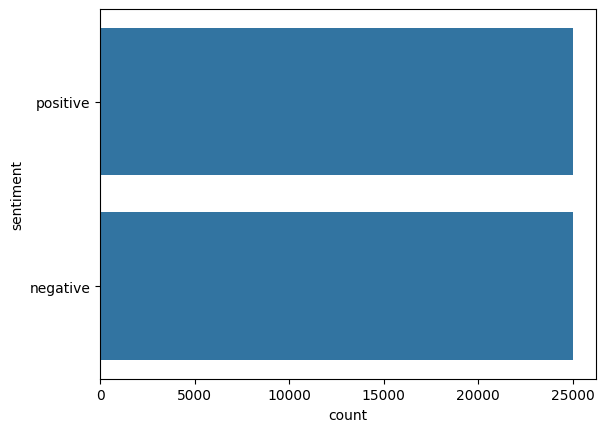

In [44]:
sns.countplot(df['sentiment'])

In [45]:
label = LabelEncoder()
df['sentiment'] = label.fit_transform(df['sentiment'])
df.head()

,review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [47]:
nltk.download('stopwords')
nltk.download('punkt')
def clean_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Stem the words
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    # Join the tokens back into a string
    cleaned_text = ' '.join(stemmed_tokens)

    return cleaned_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adachukwu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Adachukwu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
df['cleaned_review'] = df['review'].apply(clean_text)

In [49]:
df.head()

,review,sentiment,cleaned_review
0,Bromwell High is a cartoon comedy. It ran at t...,1,bromwel high cartoon comedi ran time program s...
1,Homelessness (or Houselessness as George Carli...,1,homeless houseless georg carlin state issu yea...
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,brilliant overact lesley ann warren best drama...
3,This is easily the most underrated film inn th...,1,easili underr film inn brook cannon sure flaw ...
4,This is not the typical Mel Brooks film. It wa...,1,typic mel brook film much less slapstick movi ...


In [51]:
#Flatten the list of lists:
all_words = [word for sublist in df['cleaned_review'] for word in sublist]

In [52]:
from collections import Counter

word_freq = Counter(all_words)

In [65]:
df["review_len"] = df["review"].astype(str).apply(len)
df["word_count"] = df["review"].apply(lambda x: len(str(x).split()))

In [66]:
df.head()

,review,sentiment,cleaned_review,review_len,word_count
0,Bromwell High is a cartoon comedy. It ran at t...,1,bromwel high cartoon comedi ran time program s...,806,140
1,Homelessness (or Houselessness as George Carli...,1,homeless houseless georg carlin state issu yea...,2366,428
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,brilliant overact lesley ann warren best drama...,841,147
3,This is easily the most underrated film inn th...,1,easili underr film inn brook cannon sure flaw ...,663,124
4,This is not the typical Mel Brooks film. It wa...,1,typic mel brook film much less slapstick movi ...,647,120


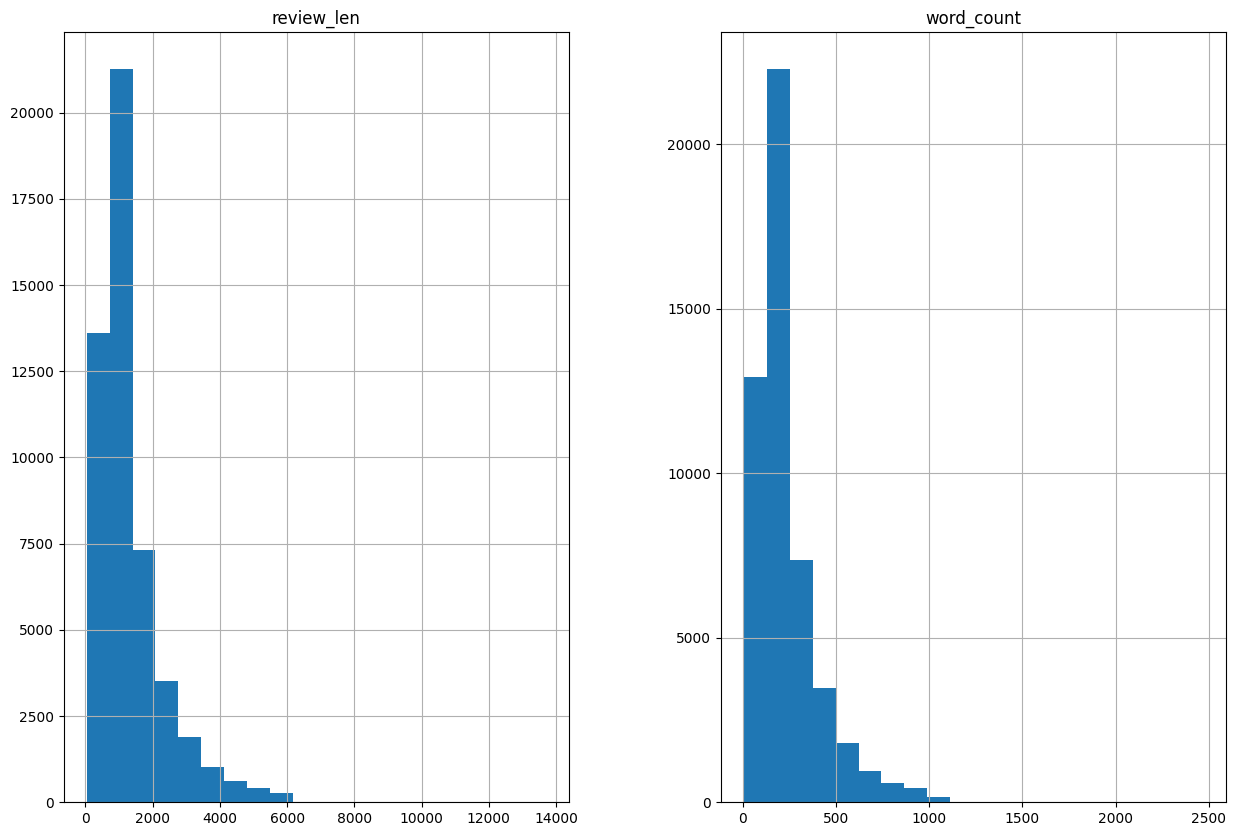

In [67]:
df[["review_len", "word_count"]].hist(bins=20, figsize=(15, 10));

In [110]:
corpus = []
corpus.append(df['cleaned_review'])

In [111]:
corpus

[0        bromwel high cartoon comedi ran time program s...
 1        homeless houseless georg carlin state issu yea...
 2        brilliant overact lesley ann warren best drama...
 3        easili underr film inn brook cannon sure flaw ...
 4        typic mel brook film much less slapstick movi ...
                                ...                        
 12495    occasion let kid watch garbag understand pathe...
 12496    anymor pretti much realiti tv show peopl make ...
 12497    basic genr thriller intercut uncomfort menagea...
 12498    four thing intrigu film firstli star carli pop...
 12499    david bryce comment nearbi except well written...
 Name: cleaned_review, Length: 50000, dtype: object]

In [112]:
X = df['cleaned_review']
y = df['sentiment']

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer

# No need to convert corpus to a list if it's already a list
cv = TfidfVectorizer(max_features=5000)
x = cv.fit_transform(X).toarray()

In [114]:
vb = cv.get_feature_names_out()
print(x[0])

[0. 0. 0. ... 0. 0. 0.]


In [115]:
x.shape

(50000, 5000)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [117]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 5000), (10000, 5000), (40000,), (10000,))

In [118]:
from sklearn.naive_bayes import MultinomialNB

# Instantiate the MultinomialNB model
nb = MultinomialNB()

# Now fit the model to the training data
nb.fit(X_train, y_train)

MultinomialNB()

In [119]:
prediction = nb.predict(X_test)

In [120]:
print(accuracy_score(y_test, prediction))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

0.852
[[4214  731]
 [ 749 4306]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4945
           1       0.85      0.85      0.85      5055

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [121]:
pd.DataFrame(np.c_[y_test, prediction], columns=['actual', 'predicted'])

,actual,predicted
0,1,1
1,1,1
2,1,1
3,1,0
4,0,0
...,...,...
9995,1,1
9996,1,1
9997,0,0
9998,0,0


In [122]:
model = nb

In [123]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open ('model.pkl', 'rb') as f:
    new_model = pickle.load(f)

In [124]:
save_cv = cv
with open('save_cv.pkl', 'wb') as f:
    pickle.dump(save_cv, f)

with open ('save_cv.pkl', 'rb') as f:
    save_cv = pickle.load(f)

In [125]:
def test_model(sentence):
    st = save_cv.transform([sentence]).toarray()
    rs = model.predict(st)[0]
    if rs == 1:
        return 'positive review'
    else:
        return 'negative review'

In [126]:
st = 'i love the movie'
rs = test_model(st)
print(rs)

positive review
